## Helper Functions

In [1]:
def export_test_csv(df,name,sep=","):
    df.to_csv("../test_exports/"+name+".csv",sep=sep)

In [2]:
def hex_to_geoboundary(value):
    if isinstance(value,str):
        return shapely.geometry.Polygon(h3.h3_to_geo_boundary(value, True))
    else:
        return np.nan

In [3]:
#Helper function to find a spot in a matrix
def findSpot(matrix,plot):
    maxrows = matrix.shape[0] #amount of rows
    maxcols = matrix.shape[1] #amount of cols
    
    rowc = -1
    for row in matrix:
        rowc = rowc+1
        itemc = -1
        for item in row:
            itemc = itemc + 1
            if (rowc + plot[0] > maxrows) or (itemc + plot[1] > maxcols):
                continue
            if item == 0: #find potential spot
                space = True
                for i in range(rowc,rowc+plot[0]):#find out whether it fits
                    for u in range(itemc,plot[1]):
                        if matrix[i,u] == 1: 
                            space = False
                if space:
                    return((rowc,itemc))
    return False


In [4]:
# Create Subplot, return figure and array of axes
def create_subplot_fig(title = "Unnamed Plot",figsize=(12,8),x=1,y=1,names=[],tight_layout=False):
    
    fig,axes = plt.subplots(nrows=y,ncols=x,figsize=figsize)
    fig = style_fig(fig,title=title,tight_layout=tight_layout)

    if x*y == 1:
        axes = np.array([axes])
    
    if x>1 and y>1:
        axes = axes.flatten()

    for ax in axes:
        ax.ticklabel_format(axis='both', style='plain')

    # case more than one
    if len(names) == x*y:
        i = 0
        for ax in axes:
            ax.set_title(names[i],fontname="Arial",y=1.0)
            i = i+1                 
    return fig,axes

#Create a gridplot that automatically arranges plots from left to right and horizontally
def create_gridplot(title="Unnamed Plot",figsize=(12,8),gridsize=(6,3),plotsizes=[(3,2),(1,1),(1,2)],direction="h",names=[],tight_layout=False):
    fig  = create_fig(title=title,figsize=figsize)
    fig=style_fig(fig,title=title,tight_layout=tight_layout)
    
    axes = []
    taken = np.zeros(gridsize)
    
    if direction == "h":
        for plot in plotsizes:
            spot = findSpot(taken,plot)
            if spot:
                for i in range(spot[0],spot[0]+plot[0]):
                    for u in range(spot[1],spot[1]+plot[1]):
                        taken[i,u] = 1
                axes.append(plt.subplot2grid(gridsize, spot, colspan=plot[1], rowspan=plot[0]))
            else: 
                print("no spot found")
    else: 
        print("Vertical Option is not implemented yet")

    for ax in axes:
        ax.ticklabel_format(axis='both', style='plain')
        
    if len(axes) == len(names):
        i = 0
        for ax in axes:
            ax.set_title(names[i],fontname="Arial",y=1.0)
            i=i+1
    return fig,axes



# Give Figure a styling
def style_fig(fig,title="Unnamed Plot",tight_layout=False):
    fig.suptitle(title, x=0.5, y=0.98, color='black',size=15,fontname="Arial")
    if tight_layout:
        print("Tight Layout activated")
        fig.tight_layout()
    return fig

# create figure
def create_fig(title = "Unnamed Plot",figsize=(12,8)):
    fig = plt.figure(figsize = figsize)
    fig = style_fig(fig,title)
    return fig

___________________________

# 0. Data Preparation

#### Python Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
from shapely import wkt
import h3
from datetime import date
import pyarrow.parquet as pq
import pyarrow as pa
from fastparquet import write
import parquet
import contextily as ctx
import seaborn as sns

#### Data Read-In

In [6]:
df = pd.read_parquet("../data/df_cleaned_21_08_2021.parquet")

In [7]:
weather_hourly = pd.read_parquet("../data/weather_transformed_23_08_2021.parquet")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1089891 entries, 489487 to 2034369
Data columns (total 43 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Trip ID                     1089891 non-null  object        
 1   Taxi ID                     1089490 non-null  object        
 2   Trip Start Timestamp        1089891 non-null  datetime64[ns]
 3   Trip End Timestamp          1089891 non-null  datetime64[ns]
 4   Trip Seconds                1089891 non-null  float64       
 5   Trip Miles                  1089891 non-null  float64       
 6   Pickup Census Tract         761542 non-null   float64       
 7   Dropoff Census Tract        758473 non-null   float64       
 8   Pickup Community Area       1011796 non-null  float64       
 9   Dropoff Community Area      991307 non-null   float64       
 10  Fare                        1089891 non-null  float64       
 11  Tips               

### Fleet Size Calculation
We first want to find out how long most taxis in our fleet operate. It seems like the majority of Taxi IDs operates throughout a significant amount of days within our analysis time frame.
We define the size of the fleet as the amount of Taxis that had at least one ride within the last 7 days.

In [9]:
days=7

# Build Table with date ranges
date_range = pd.date_range(start=df.PU_DATE.min(), end=df.DO_DATE.max(),freq="1d")
date_range_df = pd.DataFrame(index=date_range)

date_range_df["min_date"]=date_range.date-pd.Timedelta(days=days)
date_range_df["max_date"]=date_range.date

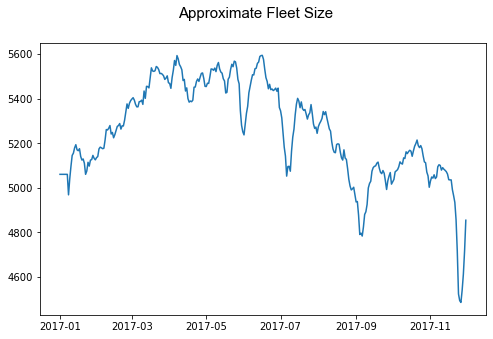

In [10]:
def get_fleet_size(min_date,max_date):
    #the number of unique Taxi IDs that have driven at least once within the given Time Frame
    return len(df[(df["PU_DATE"]>min_date) & (df["PU_DATE"]<=max_date)]["Taxi ID"].unique())

#calculate fleet size for every day in date range
fleet_size = []
for _,row in date_range_df.iterrows():
    maxdate = row["max_date"]
    mindate = row["min_date"]
    fsize = get_fleet_size(mindate,maxdate)
    fleet_size.append({"date":maxdate,
                        "fleet_size":fsize
                       })
    
fleet_size=pd.DataFrame(fleet_size)

# Set static fleet size for first days (as there is no data for)
first_value=fleet_size["fleet_size"].iloc[days-1]
i=0
for i in range(0,days-1):
    fleet_size.iloc[i,1] = first_value
    
# Plot Fleet Size over the year
fig,axes=create_subplot_fig(title = "Approximate Fleet Size",figsize=(8,5))
_= axes[0].plot(fleet_size.date,fleet_size.fleet_size)

While the way we calculate the fleet size is not perfect and depends on the condition that Taxi IDs don't change regularly, two interesting things can be noted. 
1. Fleet Size seems to rise for the summer months and then go down again for autumn, implicating that not all Taxis operate througout the whole year
2. There are some hard drops in fleet size over time, about -10% each. These could for example be due to holidays.

## Build different aggregation levels

In [11]:
df_daily = df.groupby("PU_DATE").agg(daily_trips=("PU_DATE","count"),
                                                 DATE=("PU_DATE","min"))
df_daily = pd.merge(df_daily,fleet_size,left_index=True,right_on="date",how="left")


df_hourly = df.groupby(["PU_DATE","PU_HOUR"]).agg(trip_count=("PU_HOUR","count"),
                                                 HOUR=("PU_HOUR","min"),
                                                 DATE=("PU_DATE","min"),
                                                 trip_duration = ("Trip Seconds","median"),
                                                 workday=("PU_isWorkday","min"),
                                                 mph = ("MPH","median"))
df_hourly = pd.merge(df_hourly,df_daily,how="left",left_on = "DATE",right_on="DATE")

df_hourly["relative_trips"] = (df_hourly["trip_count"] / df_hourly["daily_trips"])*100

df_weekly = df.groupby("PU_WEEK").agg(count=("Trip ID","count"))
                                      
df_monthly = df.groupby("PU_MONTH").agg(PU_MONTH_NAME=("PU_MONTH_NAME","min"),
                                        count=("Trip ID","count"),
                                        fare_avg=("Fare","mean"),
                                        tips_avg=("Tips","mean"),
                                        tolls_avg=("Tolls","mean"),
                                        extras_avg=("Extras","mean")
                                       )

df_weekday = df.groupby("PU_WEEKDAY").agg(WEEKDAY_NAME=("PU_WEEKDAY_NAME","min"),
                                         count=("Trip ID","count"))



df_hourly.head(3)

,trip_count,HOUR,DATE,trip_duration,workday,mph,daily_trips,date,fleet_size,relative_trips
0,225,1,2017-01-01,720.0,False,10.285714,2787,2017-01-01,5061,8.073197
1,331,2,2017-01-01,685.0,False,11.538462,2787,2017-01-01,5061,11.876570
2,297,3,2017-01-01,615.0,False,12.405797,2787,2017-01-01,5061,10.656620


In [12]:
weather_daily = weather_hourly.groupby("date").agg(date=("date","first"),
                                                   temperature_avg =("Temperature","mean"),
                                                   humidity_avg = ("Humidity","mean"),
                                                   windspeed_avg = ("Wind Speed","mean"),
                                                   weather_desc_dominant = ('weather_description', lambda x: x.value_counts().index[0]),
                                                   has_precipitation = ("has_precipitation","max"), #returns weather there was at least one instance of precipitation
                                                   precipitation_hours =("has_precipitation","sum") #Sums up all True Instances in a day
                                                  )

weather_monthly = weather_hourly.groupby("month").agg(date=("date","first"),
                                                   temperature_avg =("Temperature","mean"),
                                                   humidity_avg = ("Humidity","mean"),
                                                   windspeed_avg = ("Wind Speed","mean"),
                                                   weather_desc_dominant = ('weather_description', lambda x: x.value_counts().index[0]),
                                                   has_precipitation = ("has_precipitation","max"), #returns weather there was at least one instance of precipitation
                                                   precipitation_hours =("has_precipitation","sum") #Sums up all True Instances in a day
                                                  )

## Descriptive Analysis - Weather

Tight Layout activated


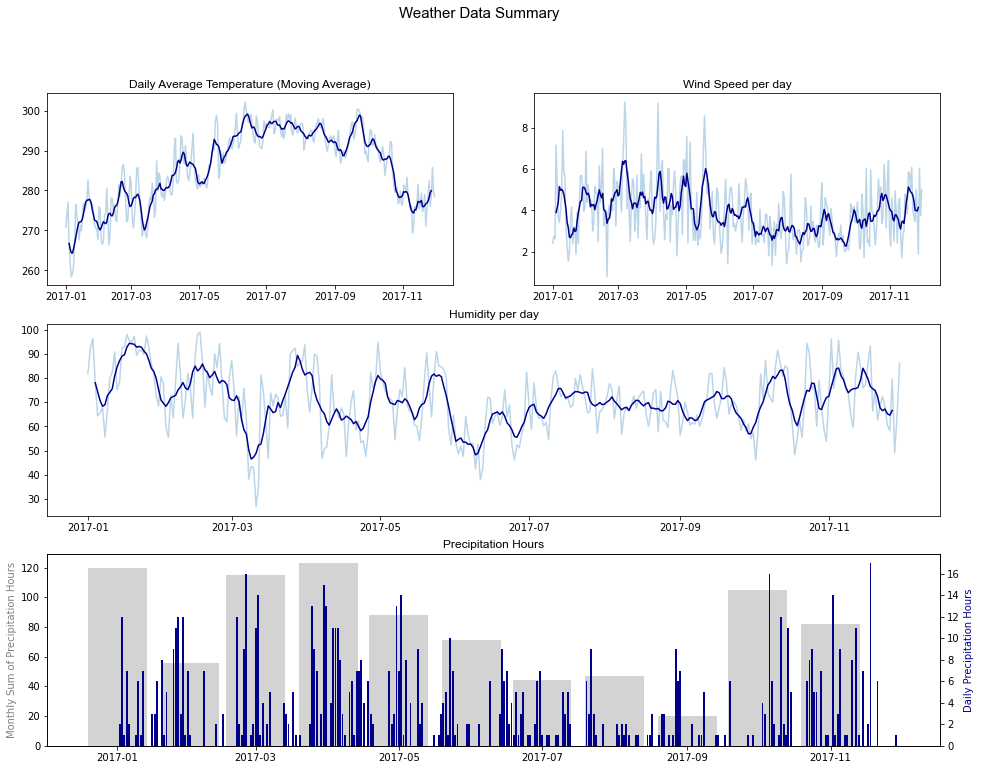

In [13]:
## Achsenbeschriftungen
fig,ax=create_gridplot(title="Weather Data Summary",
                       figsize=(16,12),
                       gridsize=(3,2),
                       plotsizes=[(1,1),(1,1),(1,2),(1,2)],
                       names=['Daily Average Temperature (Moving Average)',
                              'Wind Speed per day',
                              'Humidity per day',
                              "Precipitation Hours"],
                      tight_layout=True
                      )

# Exact Values
ax[0].plot(weather_daily["date"],weather_daily["temperature_avg"],alpha=0.3)
ax[1].plot(weather_daily["date"],weather_daily["windspeed_avg"],alpha=0.3)
ax[2].plot(weather_daily["date"],weather_daily["humidity_avg"],alpha=0.3)
ax[3].bar(weather_monthly["date"],height=weather_monthly["precipitation_hours"],
          width=25,zorder=2,color="lightgrey")
ax[3].set_ylabel("Monthly Sum of Precipitation Hours",color="grey")

# Rolling Averages
ax[0].plot(weather_daily["date"],
           weather_daily["temperature_avg"].rolling(window=7,center=True).mean(),
           alpha=1, 
           color="darkblue")

ax[1].plot(weather_daily["date"],
           weather_daily["windspeed_avg"].rolling(window=7,center=True).mean(),
           alpha=1, 
           color="darkblue")

ax[2].plot(weather_daily["date"],
           weather_daily["humidity_avg"].rolling(window=7,center=True).mean(),
           alpha=1, 
           color="darkblue")

ax3month = ax[3].twinx() 
_=ax3month.bar(weather_daily["date"],height=weather_daily["precipitation_hours"],color="darkblue",zorder=1)
_=ax3month.set_ylabel("Daily Precipitation Hours",color="darkblue")

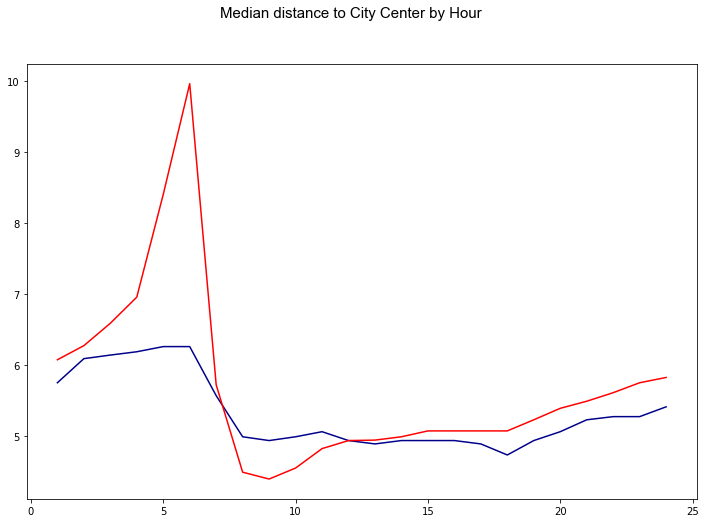

In [14]:
df_city_center=df.groupby(["PU_DATE","PU_HOUR"]).agg(PU_DATE=("PU_DATE","first"),
                                                     PU_HOUR=("PU_HOUR","first"),
                                                     pu_dist=("PU_DISTANCE_CITY","median"),
                                                     do_dist=("DO_DISTANCE_CITY","median"))
df_city_center_avg=df.groupby("PU_HOUR").agg(PU_HOUR=("PU_HOUR","first"),
                                              pu_dist=("PU_DISTANCE_CITY","median"),
                                              do_dist=("DO_DISTANCE_CITY","median"))
fig,ax=create_subplot_fig(title="Median distance to City Center by Hour",figsize=(8,6))
#for date in df_city_center["PU_DATE"].unique():
#    df_f = df_city_center[df_city_center["PU_DATE"]==date]
#    ax[0].plot(df_f["PU_HOUR"],df_f["pu_dist"],color="lightgrey")
ax[0].plot(df_city_center_avg["PU_HOUR"],df_city_center_avg["pu_dist"],color="darkblue")
ax[0].plot(df_city_center_avg["PU_HOUR"],df_city_center_avg["do_dist"],color="red")
#ax[0].set_ylim(3,20)

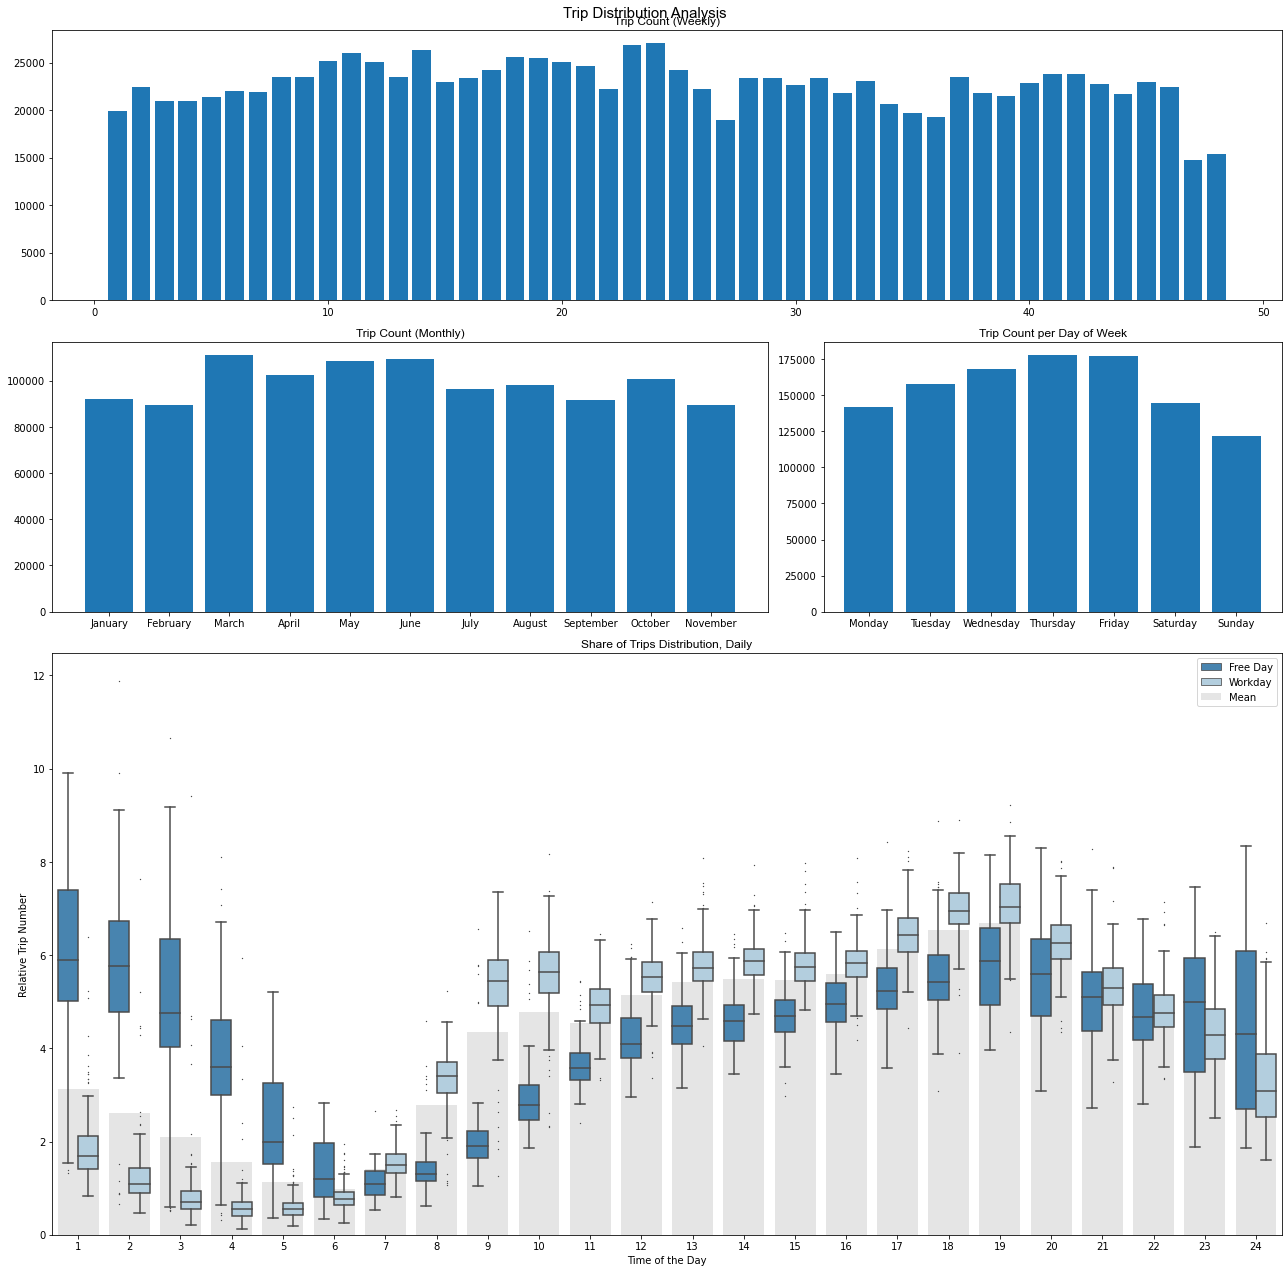

In [15]:
fig,ax=create_gridplot(title="Trip Distribution Analysis",
                       figsize=(18,18),gridsize=(4,5),plotsizes=[(1,5),(1,3),(1,2),(2,5)],
                       names=['Trip Count (Weekly)','Trip Count (Monthly)','Trip Count per Day of Week',"Share of Trips Distribution, Daily"])


ax[0].bar(df_weekly.index,df_weekly["count"])
ax[1].bar(df_monthly["PU_MONTH_NAME"],df_monthly["count"])
ax[2].bar(x=df_weekday["WEEKDAY_NAME"],height=df_weekday["count"])


color_palette = "Blues_r"
boxplot = sns.boxplot(ax = ax[3],
                 data=df_hourly, 
                 x="HOUR", 
                 y="relative_trips", 
                 hue='workday', 
                 palette=color_palette,
                 zorder = 1,
                     fliersize=0.5)


df_hourly_avg = df_hourly.groupby("HOUR").agg(avg = ("relative_trips","mean"))
avg = sns.barplot(x=df_hourly_avg.index,
                   y=df_hourly_avg.avg,
                   zorder = 0,
                   ax = ax[3],
                   color="black",
                   linewidth=20,
                   alpha = 0.1,
                 label = "average")

handles, _ = ax[3].get_legend_handles_labels()
ax[3].legend(handles, ["Free Day", "Workday","Mean"], loc="best")

fig.tight_layout()
_=ax[3].set_ylabel('Relative Trip Number')
_=ax[3].set_xlabel('Time of the Day')

Interestingly one can clearly see that on weekends there are much more taxi rides between 23h at night and 5h in the morning compared to during the week. We suspect these rides to serve customers going out and coming back from nightlife. Whereas Weekdays have a higher ride frequency during regular working hours between 9h to 20h commuting forth and back from work. 

### Analysis of MPH

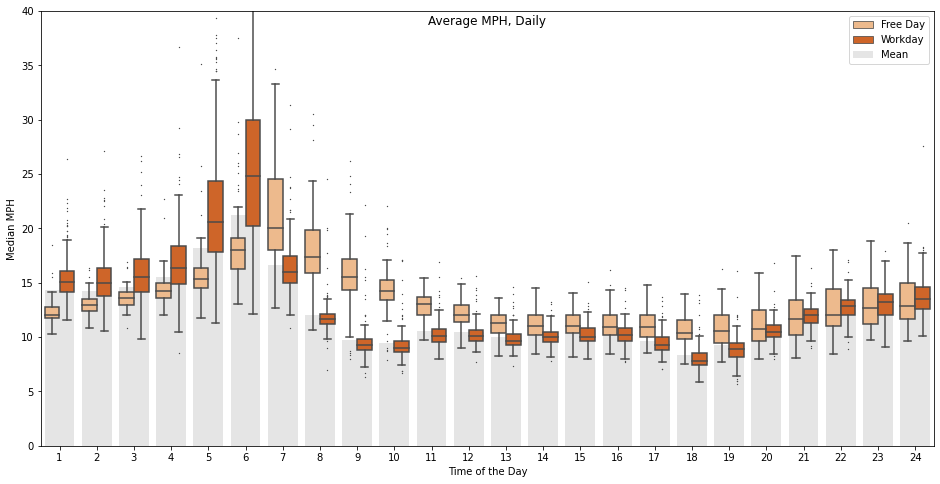

In [31]:
fig,ax = plt.subplots(1, 1, figsize=(16, 8))

color_palette = "Oranges"
boxplot = sns.boxplot(ax = ax,
                 data=df_hourly, 
                 x="HOUR", 
                 y="mph", 
                 hue='workday', 
                 palette=color_palette,
                 zorder = 1,
                     fliersize=0.5)


df_hourly_avg = df_hourly.groupby("HOUR").agg(avg = ("mph","median"))
avg = sns.barplot(x=df_hourly_avg.index,
                   y=df_hourly_avg.avg,
                   zorder = 0,
                   ax = ax,
                   color="black",
                   linewidth=20,
                   alpha = 0.1,
                 label = "average")

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Free Day", "Workday","Mean"], loc="best")

ax.set_ylim(0,40)
_=ax.set_title("Average MPH, Daily",y=1.0, pad=-14)
_=ax.set_ylabel('Median MPH')
_=ax.set_xlabel('Time of the Day')

<AxesSubplot:title={'center':'Stacked Bar Graph'}, ylabel='month'>

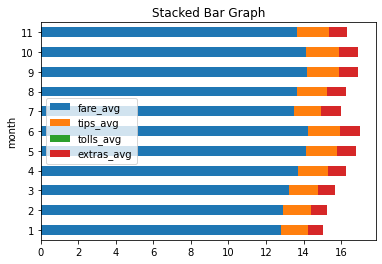

In [17]:
# Revenue pro Fahrzeug?

df_monthly_payment = df_monthly.copy()[["fare_avg","tips_avg","tolls_avg","extras_avg"]]
df_monthly_payment["month"] = df_monthly_payment.index

fig,ax=plt.subplots()
df_monthly_payment.plot(
    x = "month",
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True,
    ax=ax)

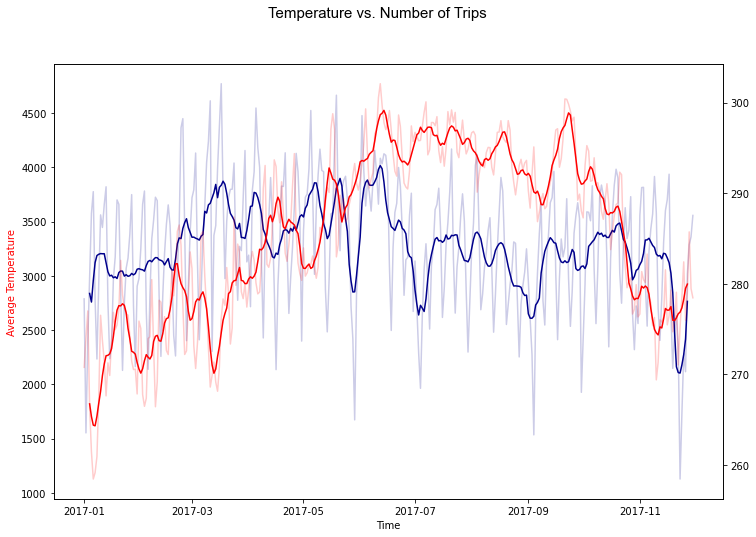

In [18]:
fig,ax = create_subplot_fig(title = "Temperature vs. Number of Trips",figsize=(12,8),x=1,y=1,names=[""])
ax[0].set_ylabel('Average Temperature', color='red')
ax[0].set_xlabel('Time')

ax[0].plot(df_daily["DATE"],df_daily["daily_trips"],alpha=0.2,color="darkblue")
ax[0].plot(df_daily["DATE"],
           df_daily["daily_trips"].rolling(window=7,center=True).mean(),
           alpha=1, 
           color="darkblue")

ax2 = ax[0].twinx()
ax2.plot(weather_daily["date"],weather_daily["temperature_avg"],alpha=0.2,color="red")
ax2.plot(weather_daily["date"],
           weather_daily["temperature_avg"].rolling(window=7,center=True).mean(),
           alpha=1, 
           color="red")


____________________________________________________

## Geospatial Analysis
For analysis of geo data, we have to limit our dataset to the rides that have valid spatial data for Pickup and Dropoff.


In [19]:
df_geo = df.copy()[(~df["PU_H3"].isnull()&~df["DO_H3"].isnull())]
left=np.round(len(df_geo.index)/len(df.index)*100,2)
print(len(df_geo.index),"Records from",len(df.index),"remained after geo-cleaning.","("+str(left)+"%)")
df_geo.head(3)

985347 Records from 1089891 remained after geo-cleaning. (90.41%)


,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,PU_HOUR,PU_isWorkday,DO_MONTH_NAME,DO_WEEKDAY_NAME,DO_WEEK,DO_DATE,DO_MONTH,DO_WEEKDAY,DO_HOUR,DO_isWorkday
489487,5487de4e97b71188efadf95669f532a5ccb08843,56f2fce86600dd132681be1323fe78ce26e60f2fffe4b3...,2017-01-09 11:45:00,2017-01-09 12:00:00,480.0,0.1,NaN,NaN,8.0,7.0,...,12,True,January,Monday,2,2017-01-09,1,0,12,True
16284335,491aabe21dbd65e2fa8efca4cdf7d6bf40f45b89,edcd6d939a065b4d0028d5219351a593d77b1b17637db3...,2017-08-17 14:30:00,2017-08-17 14:30:00,240.0,0.9,1.703132e+10,1.703108e+10,32.0,8.0,...,15,True,August,Thursday,33,2017-08-17,8,3,15,True
4052837,522fe170918a41a9eacb8c665b5a699be9db33c8,fbdfc1bdf8477e6043d2012f98283fdbc6212192a065ab...,2017-03-03 07:30:00,2017-03-03 07:45:00,360.0,0.2,NaN,NaN,6.0,8.0,...,8,True,March,Friday,9,2017-03-03,3,4,8,True


### Trajectory Visualisation
For trajectory visualisation with Kepler, we build an aggregated dataframe that contains the combination of all Pickup to Dropoff Hexagons that exist in our data. We also need to convert to our desired H3 Resolution, as this is set to 9 per default from our data cleaning part. This is way too detailed for our purposes. We choose a resolution of 7 instead.

In [20]:
h3_res = 7
df_geo["PU_H3"] = df_geo.apply(lambda x: h3.geo_to_h3(x["Pickup Centroid Latitude"],x["Pickup Centroid Longitude"],h3_res),axis=1)
df_geo["DO_H3"] = df_geo.apply(lambda x: h3.geo_to_h3(x["Dropoff Centroid Latitude"],x["Dropoff Centroid Longitude"],h3_res),axis=1)

In [21]:
def get_centroid(poly):
    return poly.centroid

def get_poly(h3_hex):
    return shapely.geometry.Polygon(h3.h3_to_geo_boundary(h3_hex,geo_json=True))


df_geo_traj = df_geo.groupby(["PU_H3","DO_H3"]).agg(count=("Trip ID","count"),
                                                            PU_H3=("PU_H3","first"),
                                                            DO_H3=("DO_H3","first"))

df_geo_traj["PU_H3_poly"]=df_geo_traj.apply(lambda x: get_poly(x["PU_H3"]),axis=1)
df_geo_traj["DO_H3_poly"]=df_geo_traj.apply(lambda x: get_poly(x["DO_H3"]),axis=1)

df_geo_traj["PU_H3_centroid"]=df_geo_traj.apply(lambda x: get_centroid(x["PU_H3_poly"]),axis=1)
df_geo_traj["DO_H3_centroid"]=df_geo_traj.apply(lambda x: get_centroid(x["DO_H3_poly"]),axis=1)

df_geo_traj["PU_x"]=df_geo_traj["PU_H3_centroid"].map(lambda p: p.x)
df_geo_traj["PU_y"]=df_geo_traj["PU_H3_centroid"].map(lambda p: p.y)
df_geo_traj["DO_x"]=df_geo_traj["DO_H3_centroid"].map(lambda p: p.x)
df_geo_traj["DO_y"]=df_geo_traj["DO_H3_centroid"].map(lambda p: p.y)

<AxesSubplot:>

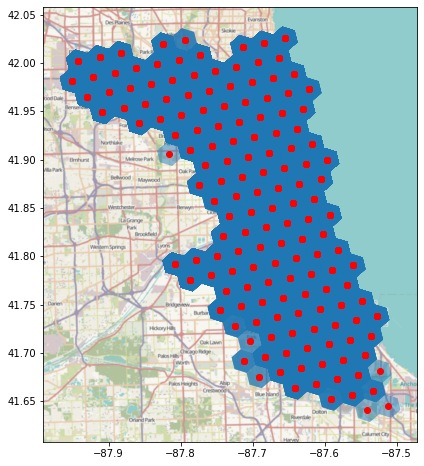

In [22]:
chicago = gpd.read_file("../data/chicago.geojson")
fig,ax=plt.subplots(figsize=(12,8))
gpd.GeoDataFrame(df_geo_traj,geometry="PU_H3_poly").plot(ax=ax,alpha=0.5)
gpd.GeoDataFrame(df_geo_traj,geometry="PU_H3_centroid").plot(color="red",ax=ax,alpha=1)
ctx.add_basemap(ax=ax,crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
chicago.plot(ax=ax,alpha=0)

In [23]:
export_test_csv(df_geo_traj[["PU_H3","DO_H3","count","PU_x","PU_y","DO_x","DO_y"]],name="trajectory_df")

In [30]:
from keplergl import KeplerGl
import json

#Import Kepler Config to 
with open("./kepler_configs/trajectorymap.json") as f:
    traj_config = json.load(f)
                            
                            
keplermap = KeplerGl(height=600,config=traj_config)
keplermap.add_data(data=df_geo_traj[["PU_H3","DO_H3","count","PU_x","PU_y","DO_x","DO_y"]], name="2my2ehvgj")

keplermap

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'vioqxss', 'type': …

In [25]:
slices = 4
slicer = 24/slices

df_geo["slice"] = np.ceil(df_geo["PU_HOUR"]/slicer).astype(int)

df_geo[["Trip Start Timestamp","PU_HOUR","slice"]].sample(10)

,Trip Start Timestamp,PU_HOUR,slice
22189247,2017-11-13 16:00:00,17,3
698100,2017-01-12 09:45:00,10,2
14222387,2017-07-18 18:15:00,19,4
14997025,2017-07-29 12:45:00,13,3
6684886,2017-04-06 16:15:00,17,3
7900805,2017-04-23 14:30:00,15,3
5758357,2017-03-25 02:30:00,3,1
14281145,2017-07-19 15:30:00,16,3
20588712,2017-10-20 20:00:00,21,4
5678638,2017-03-24 09:15:00,10,2


In [26]:
df_geo_pu = df_geo.groupby(["PU_H3","slice"]).agg(count=("PU_H3","count"),
                                                    slice=("slice","first"),
                                                    H3_id=("PU_H3","first")
                                            )
df_geo_pu["geometry"]= df_geo_pu.apply(lambda x: get_poly(x["H3_id"]),axis=1)
df_geo_pu = gpd.GeoDataFrame(df_geo_pu,geometry="geometry")


df_geo_do = df_geo.groupby(["DO_H3","slice"]).agg(count=("DO_H3","count"),
                                                    slice=("slice","first"),
                                                    H3_id=("DO_H3","first")
                                           )
df_geo_do["geometry"]= df_geo_do.apply(lambda x: get_poly(x["H3_id"]),axis=1)
df_geo_do = gpd.GeoDataFrame(df_geo_do,geometry="geometry")

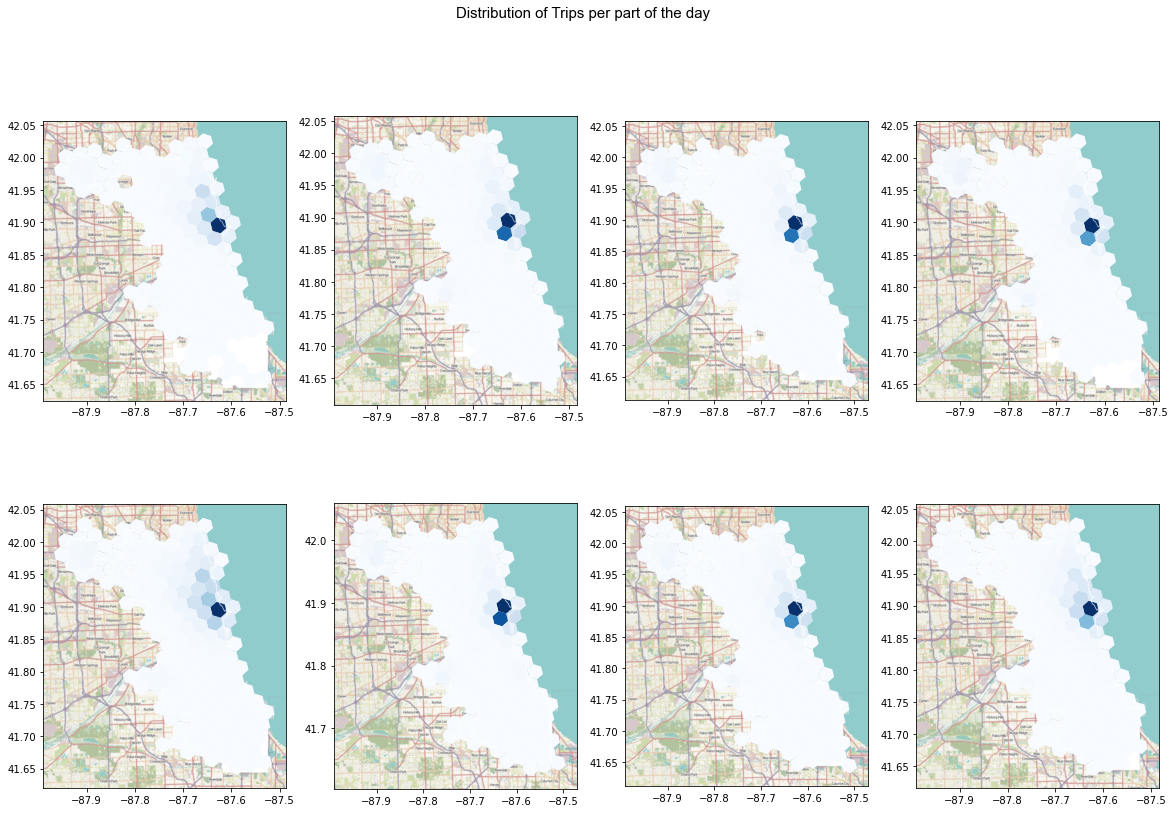

In [27]:
fig,axes = create_subplot_fig(title = "Distribution of Trips per part of the day",figsize=(20,13),x=4,y=2,names=["0-5h","6-11h","12-17h","18-23h"])
for i in range(0,4):
    chicago.plot(ax=axes[i],color="white",alpha=1)
    gpd.GeoDataFrame(df_geo_pu[df_geo_pu["slice"]==i+1],geometry="geometry").plot(ax=axes[i],column="count",cmap="Blues")
    ctx.add_basemap(ax=axes[i],crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
    chicago.plot(ax=axes[i],color="none",edgecolor="white",alpha=0.5)
    
    chicago.plot(ax=axes[i+4],color="white",alpha=1)
    gpd.GeoDataFrame(df_geo_do[df_geo_do["slice"]==i+1],geometry="geometry").plot(ax=axes[i+4],column="count",cmap="Blues")
    ctx.add_basemap(ax=axes[i+4],crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
    chicago.plot(ax=axes[i+4],color="none",edgecolor="white",alpha=0.6)
    
    
    #axes[i].set_xlim(-87.7,-87.58)
    #axes[i].set_ylim(41.8,41.95)
    
    #axes[i+4].set_xlim(-87.7,-87.58)
    #axes[i+4].set_ylim(41.8,41.95)

In [28]:
h3_res = 6
df_geo["PU_H3"] = df_geo.apply(lambda x: h3.geo_to_h3(x["Pickup Centroid Latitude"],x["Pickup Centroid Longitude"],h3_res),axis=1)
df_geo["DO_H3"] = df_geo.apply(lambda x: h3.geo_to_h3(x["Dropoff Centroid Latitude"],x["Dropoff Centroid Longitude"],h3_res),axis=1)

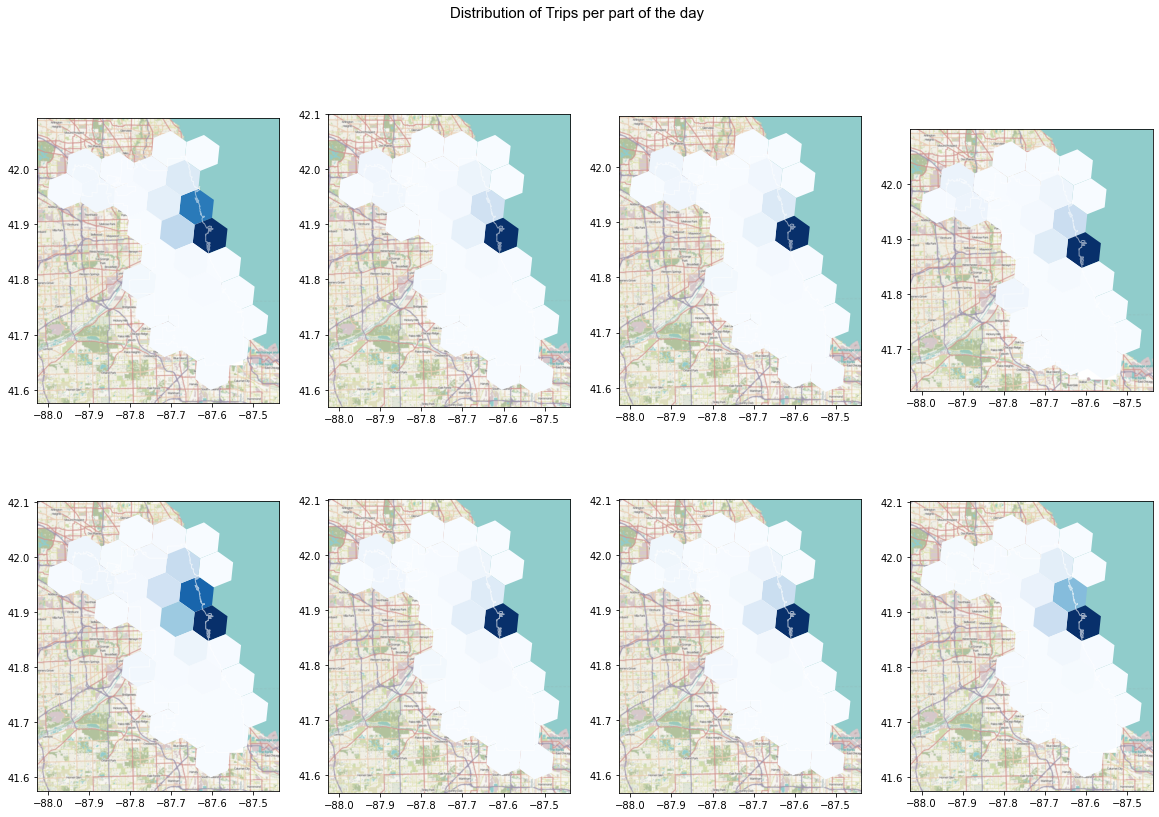

In [29]:
df_geo_pu = df_geo.groupby(["PU_H3","slice"]).agg(count=("PU_H3","count"),
                                                    slice=("slice","first"),
                                                    H3_id=("PU_H3","first")
                                            )
df_geo_pu["geometry"]= df_geo_pu.apply(lambda x: get_poly(x["H3_id"]),axis=1)
df_geo_pu = gpd.GeoDataFrame(df_geo_pu,geometry="geometry")


df_geo_do = df_geo.groupby(["DO_H3","slice"]).agg(count=("DO_H3","count"),
                                                    slice=("slice","first"),
                                                    H3_id=("DO_H3","first")
                                           )
df_geo_do["geometry"]= df_geo_do.apply(lambda x: get_poly(x["H3_id"]),axis=1)
df_geo_do = gpd.GeoDataFrame(df_geo_do,geometry="geometry")

fig,axes = create_subplot_fig(title = "Distribution of Trips per part of the day",figsize=(20,13),x=4,y=2,names=["0-5h","6-11h","12-17h","18-23h"])
for i in range(0,4):
    chicago.plot(ax=axes[i],color="white",alpha=1)
    gpd.GeoDataFrame(df_geo_pu[df_geo_pu["slice"]==i+1],geometry="geometry").plot(ax=axes[i],column="count",cmap="Blues")
    ctx.add_basemap(ax=axes[i],crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
    chicago.plot(ax=axes[i],color="none",edgecolor="white",alpha=0.5)
    
    chicago.plot(ax=axes[i+4],color="white",alpha=1)
    gpd.GeoDataFrame(df_geo_do[df_geo_do["slice"]==i+1],geometry="geometry").plot(ax=axes[i+4],column="count",cmap="Blues")
    ctx.add_basemap(ax=axes[i+4],crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
    chicago.plot(ax=axes[i+4],color="none",edgecolor="white",alpha=0.6)

# Backup

Text(0.5, 1.0, 'Duration')

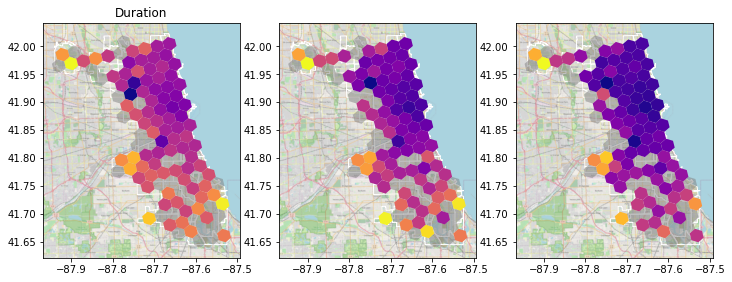

In [140]:
fig,axes = plt.subplots(1,3,figsize=(12,8))
duration_plot = plot_chicago_heatmap(df_grouped_pu,axes[0],"H3","avgduration",h3_gdf)
distance_plot = plot_chicago_heatmap(df_grouped_pu,axes[1],"H3","avgdistance",h3_gdf)
revenue_plot = plot_chicago_heatmap(df_grouped_pu,axes[2],"H3","revenue_per_ride",h3_gdf)

axes[0].set_title("Duration")

## Write results in parquet file 